In [3]:
import cellrank as cr
import scanpy as sc
import scvelo as scv
from cellrank.kernels import VelocityKernel
from cellrank.estimators import GPCCA
import numpy as np
import matplotlib.pyplot as plt

In [8]:
adata = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/gastrulation/adata_gex_velocities.h5ad")
adata.obsm["X_pca"] = adata.layers["X_pca"].copy()
adata.layers["velocity"] = adata.layers["GEX_velocity"].copy()
sc.pp.neighbors(adata, use_rep="X_pca")
scv.tl.umap(adata)
adata.X = np.ones((31403,50))

In [9]:
vk = VelocityKernel(adata, xkey="X_pca", vkey="GEX_velocity").compute_transition_matrix()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31403/31403 [00:08<00:00, 3816.66cell/s]


In [10]:
g = GPCCA(vk)

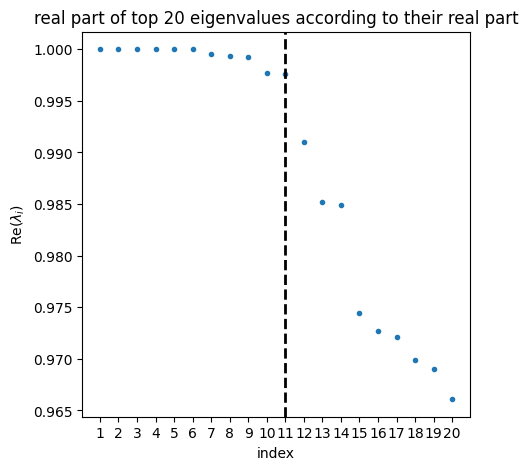

In [11]:
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

In [12]:
results = {}

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/pygpcca/_gpcca.py:1274: UserWarning: Stationary distribution couldn't be calculated. Reason: This matrix is reducible. The second largest eigenvalue is (0.999999999999973+0j)..
  warnings.warn(f"Stationary distribution couldn't be calculated. Reason: {e}.")
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


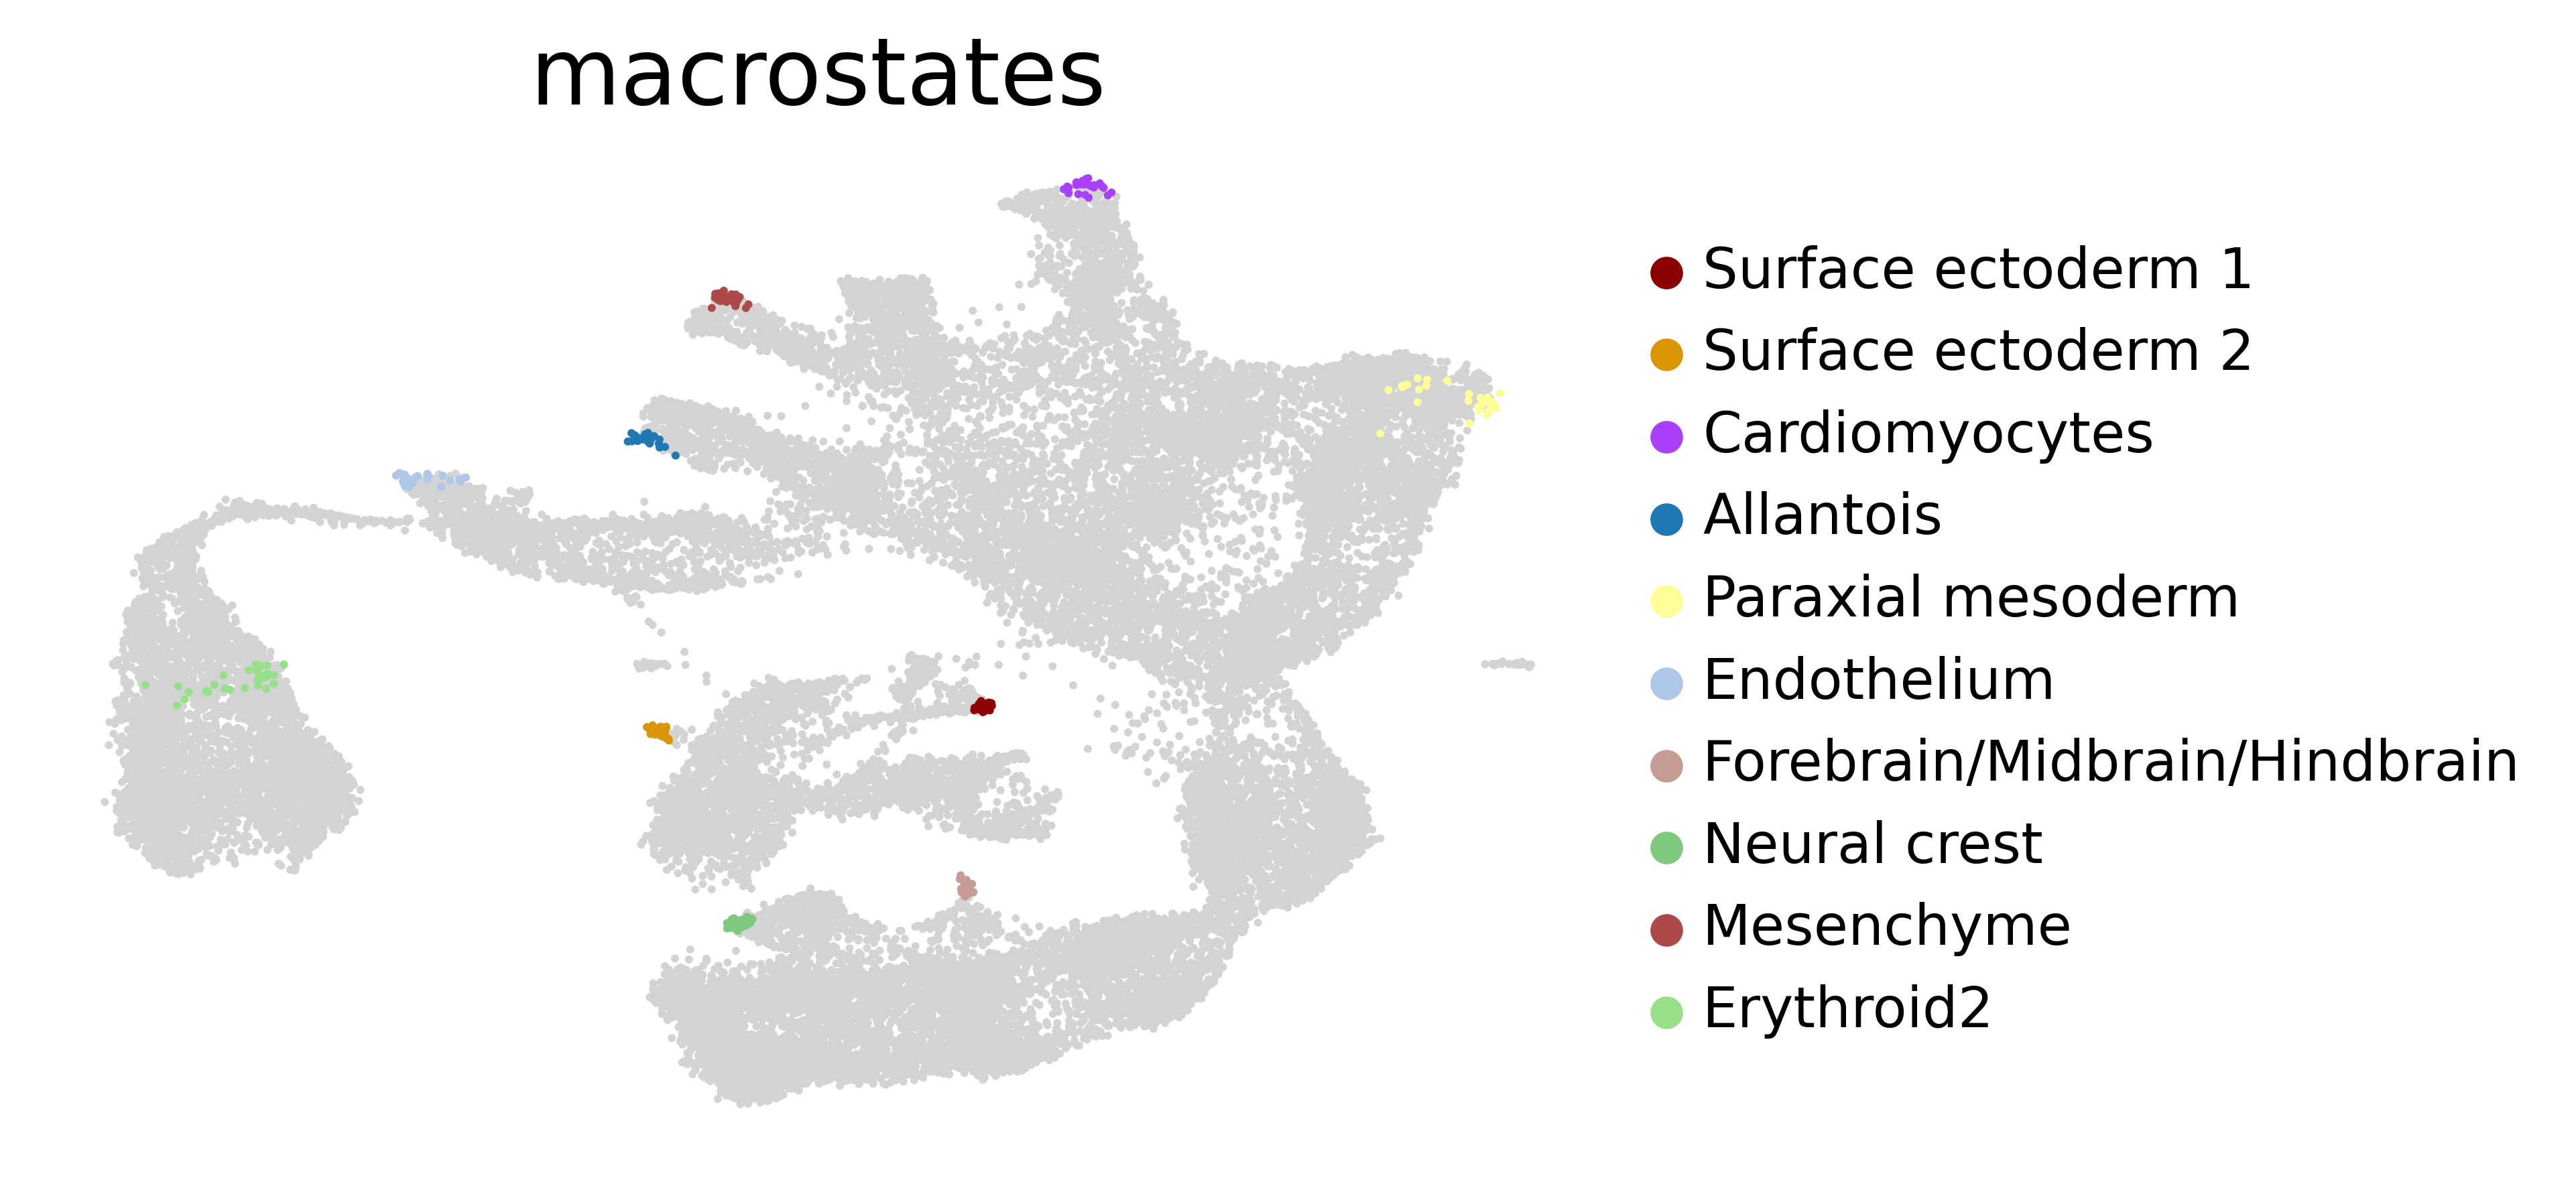

In [13]:
g.compute_macrostates(n_states=10, cluster_key="celltype")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

In [ ]:
g.compute_macrostates(n_states=11, cluster_key="celltype")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

In [ ]:
results['consistency'] = 4

In [ ]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar_1", "Acinar_2", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

In [ ]:
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar_1", "Acinar_2", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"],
    cluster_key='celltype',
    clusters=['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 7),
    title="",
    #save="transprobs_wot.png"
)

In [ ]:
adata.uns["velocity_graph"] = vk.transition_matrix

scv.set_figure_params('scvelo', transparent=True, fontsize=10, dpi_save=400,color_map='viridis')
fig = plt.figure()
ax = scv.pl.velocity_embedding_stream(adata, basis="umap", smooth=0.5, title="", legend_loc="none", show=False)
legend =ax.legend(bbox_to_anchor=[1.25, 1.5], loc='upper center', ncol=6,frameon=True, prop={'size': 18})
#plt.savefig("velstream_pancreas1415_scvelo", dpi=800, bbox_inches='tight')